In [1]:
import pandas as pd
import random
import datetime
import numpy as np
from itertools import repeat
import pickle
import math
import time
import gurobipy as gp
from gurobipy import *

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
%matplotlib nbagg
import random

In [118]:
def create_dataframe(excel_data_path):
    """
    Takes in order data in excel format, returns order and equipments in pandas dataframes

    """
    xls = pd.ExcelFile(excel_data_path)
    items = pd.read_excel(xls, 'items')
    bins = pd.read_excel(xls, 'bins')

    return items, bins

def sort_items(items, *columns):
    """
    :param items: items datafram
    :param columns: colums that will be sorted
    :return: sorted items dataframe
    """
    column_list = list(columns)
    bool_list = [False] * len(column_list)
    items.sort_values(by=column_list, ascending=bool_list, inplace=True)
    return items

#randomize sorting based on weight
def randomized_weight_sort(items):
    """
    :param items: dataframe
    :return: sorted dataframe based on the condition
    """
    length = len(items) if len(items) % 2 == 0 else len(items) - 1
    for i in range(0, length, 2):
        if random.random() < 0.5:
            if (0.7 < (items.iloc[i, :].weight) / (items.iloc[i + 1, :].weight) < 1.3):
                a, b = items.iloc[i, :].copy(), items.iloc[i + 1, :].copy()
                items.iloc[i, :], items.iloc[i + 1, :] = b, a
    return items


In [119]:
filepath="C:/Users/Ashrafur.Rahman/OneDrive - Blume Global/Data and Codes/Container Loading/data/3d-bin-packing/3d-bin-packing-toy-large-29.xlsx"

items, bins=create_dataframe(filepath)
items=sort_items(items,'volume','weight')
items=randomized_weight_sort(items)

In [120]:
length=len(items) if len(items)%2==0 else len(items)-1
for i in range(0,length,2):
    if random.random()<0.5:
        if (0.7< items.iloc[i].weight/items.iloc[i+1].weight< 1.3):
            a, b = items.iloc[i, :].copy(), items.iloc[i+1, :].copy()
            items.iloc[i, :], items.iloc[i+1, :] = b, a


In [121]:
ww=dict(zip(items.item,items.width))
ll=dict(zip(items.item,items.length))
hh=dict(zip(items.item,items.height))
weight=dict(zip(items.item,items.weight))
volume=dict(zip(items.item,items.volume))
p_class=dict(zip(items.item,items.p_class))
customer=dict(zip(items.item,items.customer))
priority=dict(zip(items.item,items.priority))
#W=dict(zip(bins.bin,bins.width))
#H=dict(zip(bins.bin,bins.height))
#L=dict(zip(bins.bin,bins.length))

In [122]:
bin=dict(zip(bins.bin,zip(bins.length,items.height,items.width)))

#bin characteristics
L={}
W={}
H={}
volume_capacity={}
weight_capacity={}
volume_utilization={}
weight_utilization={}
bins=[1,2,3]
zones=4

orientations=['o1','o2','o3','o4','o5','o6']

weight_capacity_zone={}
for e in bins:
    L[e]=30
    W[e]=10
    H[e]=10

    volume_capacity[e]=L[e]*H[e]*W[e]
    weight_capacity[e]=25000

In [123]:
bins

[1, 2, 3]

In [124]:
#iteration results
IP_iter={}
volume_utilization_iter={}
weight_utilization_iter={}
c_gravity_y_iter={}
dev_gravity_center_iter={}

x_iter={}
y_iter={}
z_iter={}

l_iter={}
w_iter={}
h_iter={}

iterations=100

In [125]:
%%capture output --no-stderr

for it in range(1,iterations+1):
    print("======================================")
    print("^^^ For iteration ",it, ' in ', iterations)
    print("======================================")

    I=items.item.tolist() #list of items need to be packed
    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins

    x_e={} #x coordinate of insertion point (RBL) of items in bins
    y_e={} #y coordinate of insertion point (RBL) of items in bins
    z_e={} #z coordinate of insertion point (RBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins



    #IUU=[]
    #I_retry=[] #items that will be tried again in the sam
    #if IU!= []

    for e in bins:

        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)


       #start with (0,0,0) in the bin

        P=[(0,0,0)] #starting potential point in
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[]

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU


            for i in IU:
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]


                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weigh.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)



                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones




                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))
                        print ("*** P after adding new  potential points :", P)

                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i

                        #stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)


                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or retrying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z


        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]


    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e


    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e




print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [156]:
volume_utilization_iter

{1: {1: 0.7213333333333334, 2: 0.495, 3: 0.0},
 2: {1: 0.8343333333333334, 2: 0.382, 3: 0.0},
 3: {1: 0.7386666666666667, 2: 0.4776666666666667, 3: 0.0},
 4: {1: 0.841, 2: 0.37533333333333335, 3: 0.0},
 5: {1: 0.7286666666666667, 2: 0.4876666666666667, 3: 0.0},
 6: {1: 0.8526666666666667, 2: 0.3636666666666667, 3: 0.0},
 7: {1: 0.7416666666666667, 2: 0.4746666666666667, 3: 0.0},
 8: {1: 0.865, 2: 0.35133333333333333, 3: 0.0},
 9: {1: 0.7433333333333333, 2: 0.473, 3: 0.0},
 10: {1: 0.6133333333333333, 2: 0.603, 3: 0.0},
 11: {1: 0.7316666666666667, 2: 0.4846666666666667, 3: 0.0},
 12: {1: 0.7173333333333334, 2: 0.499, 3: 0.0},
 13: {1: 0.7796666666666666, 2: 0.43666666666666665, 3: 0.0},
 14: {1: 0.762, 2: 0.4543333333333333, 3: 0.0},
 15: {1: 0.7046666666666667, 2: 0.5116666666666667, 3: 0.0},
 16: {1: 0.7313333333333333, 2: 0.485, 3: 0.0},
 17: {1: 0.7693333333333333, 2: 0.447, 3: 0.0},
 18: {1: 0.7933333333333333, 2: 0.423, 3: 0.0},
 19: {1: 0.829, 2: 0.3873333333333333, 3: 0.0},
 20

In [93]:
max_volume_utilization_iter={}
for it,bins in volume_utilization_iter.items():
    maximum=max(v for v in bins.values())
    max_volume_utilization_iter[it]=maximum

In [95]:
max_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    max_w=max(v for v in bins.values())
    max_weight_utilization_iter[it]=max_w

In [129]:
modified_weight_utilization={}
for it,bins in weight_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_weight_utilization[it]=avg
modified_volume_utilization={}
for it,bins in volume_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_volume_utilization[it]=avg
Avg_c_gravity_y_iter={}
for it,bins in c_gravity_y_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_c_gravity_y_iter[it]=avg
dev_Avg_c_gravity_y_iter={a:abs(b-5) for a,b in Avg_c_gravity_y_iter.items() }

max_iter_volume = max(modified_volume_utilization, key=modified_volume_utilization.get)
max_iter_weight = max(modified_weight_utilization, key=modified_weight_utilization.get)
min_iter_gravity=min(dev_Avg_c_gravity_y_iter, key=dev_Avg_c_gravity_y_iter.get)

(max_iter_volume,max_iter_weight,min_iter_gravity)

(74, 94, 91)

In [154]:
modified_volume_utilization

{1: 0.7213333333333334,
 2: 0.8343333333333334,
 3: 0.7386666666666667,
 4: 0.841,
 5: 0.7286666666666667,
 6: 0.8526666666666667,
 7: 0.7416666666666667,
 8: 0.865,
 9: 0.7433333333333333,
 10: 0.6133333333333333,
 11: 0.7316666666666667,
 12: 0.7173333333333334,
 13: 0.7796666666666666,
 14: 0.762,
 15: 0.7046666666666667,
 16: 0.7313333333333333,
 17: 0.7693333333333333,
 18: 0.7933333333333333,
 19: 0.829,
 20: 0.8163333333333334,
 21: 0.744,
 22: 0.7426666666666667,
 23: 0.923,
 24: 0.771,
 25: 0.9603333333333334,
 26: 0.779,
 27: 0.7373333333333333,
 28: 0.8673333333333333,
 29: 0.6973333333333334,
 30: 0.7773333333333333,
 31: 0.6996666666666667,
 32: 0.8676666666666667,
 33: 0.6426666666666667,
 34: 0.7333333333333333,
 35: 0.919,
 36: 0.834,
 37: 0.729,
 38: 0.753,
 39: 0.9016666666666666,
 40: 0.6893333333333334,
 41: 0.7543333333333333,
 42: 0.7406666666666667,
 43: 0.8186666666666667,
 44: 0.6746666666666666,
 45: 0.711,
 46: 0.7126666666666667,
 47: 0.8783333333333333,
 48

In [153]:
iterations,deviations=zip(*dev_Avg_c_gravity_y_iter.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,deviations)

C:\Users\ASHRAF~1.RAH\AppData\Local\Temp/ipykernel_2100/1244489708.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16 ,4))


<IPython.core.display.Javascript object>

<BarContainer object of 100 artists>

In [151]:
iterations,vol_util=zip(*modified_volume_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,vol_util)

<IPython.core.display.Javascript object>

<BarContainer object of 100 artists>

In [152]:
iterations,weight_util=zip(*modified_weight_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,weight_util)

<IPython.core.display.Javascript object>

<BarContainer object of 100 artists>

In [61]:
max(Avg_c_gravity_y_iter.values())

5.92693999484501

In [47]:
used_bins

[0.7466666666666667, 0.4696666666666667, 0.0]

In [25]:
Avg_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_weight_utilization_iter[it]=avg


In [26]:
Avg_volume_utilization_iter={}
for it,bins in volume_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_volume_utilization_iter[it]=avg

In [276]:
Avg_weight_utilization_iter

{1: 0.42762,
 2: 0.42762,
 3: 0.42762,
 4: 0.42762,
 5: 0.42762,
 6: 0.42762,
 7: 0.42762,
 8: 0.42762,
 9: 0.42762,
 10: 0.42762,
 11: 0.42762,
 12: 0.42762,
 13: 0.42762,
 14: 0.42762,
 15: 0.42762,
 16: 0.42762,
 17: 0.42762,
 18: 0.42762,
 19: 0.42762,
 20: 0.38754,
 21: 0.42762,
 22: 0.42762,
 23: 0.42762,
 24: 0.42762,
 25: 0.42762,
 26: 0.42762,
 27: 0.42762,
 28: 0.42762,
 29: 0.42762,
 30: 0.42762,
 31: 0.41759999999999997,
 32: 0.42762,
 33: 0.42762,
 34: 0.42762,
 35: 0.42762,
 36: 0.42762,
 37: 0.42762,
 38: 0.42762,
 39: 0.42762,
 40: 0.42762,
 41: 0.42762,
 42: 0.42762,
 43: 0.42762,
 44: 0.42762,
 45: 0.42762,
 46: 0.42762,
 47: 0.42762,
 48: 0.42762,
 49: 0.42762,
 50: 0.42762}

In [ ]:
plt.scatter(list(max_weight_utilization_iter.values()), list(max_volume_utilization_iter.values()),  markersize=16, label='Non Pareto-optimal')
#_=plt.title('The input data', fontsize=15)
plt.xlabel('Objective 1', fontsize=16)
plt.ylabel('Objective 2', fontsize=16)
#plt.show()

In [ ]:
list(max_weight_utilization_iter.values())

In [157]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mycolorpy import colorlist as mcp

from itertools import product
%matplotlib inline
%matplotlib nbagg
from matplotlib import cm

used_iter=max_iter_volume
flb={}
flt={}
frt={}
frb={}

rlb={}
rlt={}
rrt={}
rrb={}


nrows=len(bins)
fig = plt.figure(figsize=(24 ,24))


colors={}
classes=list(set(p_class.values()))
#size=len(set(p_class.values()))
c=mcp.gen_color(cmap="Paired",n=len(classes))
for i in range(len(classes)):
    colors[classes[i]]=c[i]
color={}
for  i,value in p_class.items():
    color[i]=colors[value]

# create list of corners
#z = list(product([-1,1], repeat=3))
for e in bins:

    x={}
    y={}
    z={}

    l={}
    w={}
    h={}


    ax = fig.add_subplot(nrows,1,e, projection='3d')
    FLB=(0,0,0)
    FLT=(0,0,H[e])
    FRT=(0,W[e],H[e])
    FRB=(0,W[e],0)

    RLB=(L[e],0,0)
    RLT=(L[e],0,H[e])
    RRT=(L[e],W[e],H[e])
    RRB=(L[e],W[e],0)

    bin_verts=[  [FLB,FLT,FRT,FRB],
             [FLB,FLT,RLT,RLB],
             [FLT,FRT,RRT,RLT],
             [RRT,FRT,FRB,RRB],
             [RLB,FLB,FRB,RRB],
             [RLB,RLT,RRT,RRB ]
             ]
    ax.set_xlim3d(0,L[e])
    ax.set_ylim3d(0,L[e])
    ax.set_zlim3d(0,L[e])
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_zlabel('Height')
    ax.grid(False)
# plot sides
    ax.add_collection3d(Poly3DCollection(bin_verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.025))

    for c in p_class:
        c=mcp.gen_color(cmap="seismic",n=5)
#for e in IP_iter_update.keys():

    for i in IP_iter[used_iter][e]:
        x[i]=x_iter[used_iter][e][i]
        y[i]=y_iter[used_iter][e][i]
        z[i]=z_iter[used_iter][e][i]

        l[i]=l_iter[used_iter][e][i]
        w[i]=w_iter[used_iter][e][i]
        h[i]=h_iter[used_iter][e][i]

        flb[i]=(x[i],y[i],z[i])
        flt[i]=(x[i],y[i],z[i]+h[i])
        frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
        frb[i]=(x[i],y[i]+w[i],z[i])

        rlb[i]=(x[i]+l[i],y[i],z[i])
        rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
        rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
        rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

        box_verts=[  [flb[i],flt[i],frt[i],frb[i]],
                [flb[i],flt[i],rlt[i],rlb[i]],
                [flt[i],frt[i],rrt[i],rlt[i]],
                [rrt[i],frt[i],frb[i],rrb[i]],
                [rlb[i],flb[i],frb[i],rrb[i]],
                [rlb[i],rlt[i],rrt[i],rrb[i]]
                ]



        ax.add_collection3d(Poly3DCollection(box_verts,facecolors=color[i], linewidths=1, edgecolors='black', alpha=1))
        ax.text((x[i]+l[i]),(y[i]+w[i]/2),(z[i]+h[i]/2),   i,'y', size=8, zorder=30,color='black')
        ax.text((x[i]+l[i]/2),(y[i]),(z[i]+h[i]/2),   i,'x', size=8, zorder=30,color='black')
        ax.text((x[i]+l[i]/2),(y[i]+w[i]/2),(z[i]+h[i]),   i,'x', size=8, zorder=30
            ,
    color='black')
#'(%d, %d, %d), dir=%s' % (x, y, z, zdir)

"""
label1 = "FRONT"
label2 = "REAR"
#label3 = "BOTTOM"
ax.text(0, W/2, H/2, '%s' % (label1), size=10,zorder=7, color='black')
ax.text(L, W/2, H/2, '%s' % (label2), size=10,zorder=10, color='blue')
#ax.text(6, 2, 0, '%s' % (label3), size=20,zorder=5, color='blue')
#ax.view_init(elev=0, azim=45)
"""
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
plt.savefig('3-d-loading.png')

In [ ]:
classes=set(p_class.values())

In [ ]:
items

In [144]:
total=sum(items.volume)
total

3649

In [ ]:
for i in classes:
    print(i)

In [145]:
30*10*10

3000

In [98]:
color={i:v for i,v in p_class.items()}

{'A': '#0000ff', 'B': '#0055d4', 'C': '#00aaaa', 'D': '#00ff80'}

In [96]:
colors[3]

'#00ff80'

In [100]:
color

{13: '#0000ff',
 11: '#00aaaa',
 5: '#0000ff',
 27: '#00aaaa',
 6: '#0055d4',
 26: '#0055d4',
 29: '#0000ff',
 8: '#00ff80',
 3: '#00aaaa',
 24: '#00ff80',
 2: '#0055d4',
 23: '#00aaaa',
 4: '#00ff80',
 20: '#00ff80',
 25: '#0000ff',
 19: '#00aaaa',
 7: '#00aaaa',
 9: '#0000ff',
 12: '#00ff80',
 28: '#00ff80',
 14: '#0055d4',
 1: '#0000ff',
 10: '#0055d4',
 17: '#0000ff',
 21: '#0000ff',
 18: '#0055d4',
 15: '#00aaaa',
 16: '#00ff80',
 22: '#0055d4'}

In [59]:
MPL = 0
for i in I[4:5]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (0, 0, 3)
This is p[0]:  0
second level worked
third level worked
sa/sa_p worked
0.8333333333333334 [(0, 0, 3)]
This is P  (6, 5, 0)
This is P  (6, 0, 2)
This is p[0]:  6
second level worked
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
This is P  (4, 4, 0)


In [61]:
MPL = 0
for i in I[6:7]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (6, 5, 0)
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
sa/sa_p worked
0.14035087719298245 [(13, 0, 0)]
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
third level worked
sa/sa_p worked
0.3333333333333333 [(13, 0, 0), (9, 0, 1)]
This is P  (4, 4, 0)
This is P  (5, 0, 3)
This is p[0]:  5
second level worked
This is P  (0, 0, 4)
This is p[0]:  0
second level worked
third level worked
sa/sa_p worked
0.4 [(13, 0, 0), (9, 0, 1), (0, 0, 4)]
This is P  (6, 3, 2)


In [62]:
MPL = 0
for i in I[7:8]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (6, 5, 0)
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
sa/sa_p worked
0.10526315789473684 [(13, 0, 0)]
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
third level worked
sa/sa_p worked
0.25 [(13, 0, 0), (9, 0, 1)]
This is P  (4, 4, 0)
This is p[0]:  4
second level worked
third level worked
This is P  (5, 0, 3)
This is p[0]:  5
second level worked
This is P  (6, 3, 2)
This is p[0]:  6
second level worked
third level worked
sa/sa_p worked
1.0 [(13, 0, 0), (9, 0, 1), (6, 3, 2)]
This is P  (2, 0, 4)
This is p[0]:  2
second level worked
third level worked
This is P  (0, 0, 6)


In [63]:
MPL = 0
for i in I[8:9]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (6, 5, 0)
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
sa/sa_p worked
0.14035087719298245 [(13, 0, 0)]
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
third level worked
sa/sa_p worked
0.3333333333333333 [(13, 0, 0), (9, 0, 1)]
This is P  (4, 4, 0)
This is P  (5, 0, 3)
This is p[0]:  5
second level worked
This is P  (2, 0, 4)
This is p[0]:  2
second level worked
third level worked
sa/sa_p worked
0.6666666666666666 [(13, 0, 0), (9, 0, 1), (2, 0, 4)]
This is P  (0, 0, 6)
This is P  (6, 3, 4)


In [64]:
MPL = 0
for i in I[8:9]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (6, 5, 0)
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
sa/sa_p worked
0.14035087719298245 [(13, 0, 0)]
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
third level worked
sa/sa_p worked
0.3333333333333333 [(13, 0, 0), (9, 0, 1)]
This is P  (4, 4, 0)
This is P  (5, 0, 3)
This is p[0]:  5
second level worked
This is P  (0, 0, 6)
This is P  (6, 3, 4)
This is P  (4, 0, 4)
This is p[0]:  4
second level worked
This is P  (2, 0, 5)
This is p[0]:  2
second level worked
third level worked
sa/sa_p worked
1.0 [(13, 0, 0), (9, 0, 1), (2, 0, 5)]


In [65]:
MPL = 0
for i in I[9:10]:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











This is P  (6, 5, 0)
This is P  (13, 0, 0)
This is p[0]:  13
second level worked
third level worked
sa/sa_p worked
0.10526315789473684 [(13, 0, 0)]
This is P  (9, 0, 1)
This is p[0]:  9
second level worked
third level worked
sa/sa_p worked
0.25 [(13, 0, 0), (9, 0, 1)]
This is P  (4, 4, 0)
This is P  (5, 0, 3)
This is p[0]:  5
second level worked
This is P  (0, 0, 6)
This is P  (6, 3, 4)
This is p[0]:  6
second level worked
This is P  (4, 0, 4)
This is p[0]:  4
second level worked


In [1070]:
MPL = 0
for i in I:

    p_feasible=[]
    sa_ratio=0
    for p in P:
        print('This is P ',p)
        if stack_p[p]==1:

            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                print('This is p[0]: ',p[0])
                print("second level worked")
                #if sa_p[p]>sa[i]:
                if l[i]<=l_available[p] and w[i]<=w_available[p]:
                    print('third level worked')
                    if sa[i]/sa_p[p]>=sa_ratio:
                        print("sa/sa_p worked")
                        sa_ratio=sa[i]/sa_p[p]
                        p_feasible.append(p)
                        print(sa_ratio, p_feasible)

    if p_feasible==[]:
        I_retry.append(i)
        break

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l_available[p_best]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l_available[p_best]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w_available[p_best]
    w_available[(x[i],y[i]+w[i],z[i])]=w_available[p_best]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    if l_available[(x[i]+l[i],y[i],z[i])]==0:
        P.remove((x[i]+l[i],y[i],z[i]))
    if w_available[(x[i],y[i]+w[i],z[i])]==0:
        P.remove((x[i],y[i]+w[i],z[i]))

    for pp, t1 in enumerate(P):
        for t2 in P[pp+1:]:
            if t1[1:]==t2[1:]:
                if t1[0]<t2[0]:
                    P.remove(t2)
                else:
                    P.remove(t1)
    for ppp, tt1 in enumerate(P):
        for tt2 in P[ppp+1:]:
            if tt1[0::2]==tt2[0::2]:
                if tt1[1]<tt2[1]:
                    P.remove(tt2)
                else:
                    P.remove(tt1)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])











[[(0, 0, 5), (0, 0, 6), (0, 3, 6), (0, 3, 5)],
 [(0, 0, 5), (0, 0, 6), (2, 0, 6), (2, 0, 5)],
 [(0, 0, 6), (0, 3, 6), (2, 3, 6), (2, 0, 6)],
 [(2, 3, 6), (0, 3, 6), (0, 3, 5), (2, 3, 5)],
 [(2, 0, 5), (0, 0, 5), (0, 3, 5), (2, 3, 5)],
 [(2, 0, 5), (2, 0, 6), (2, 3, 6), (2, 3, 5)]]

In [1048]:
x,y,z

({7: 0, 1: 0, 2: 6, 5: 6, 4: 12, 6: 8, 3: 6, 8: 16, 9: 18, 10: 0},
 {7: 0, 1: 0, 2: 0, 5: 0, 4: 0, 6: 0, 3: 0, 8: 0, 9: 0, 10: 0},
 {7: 0, 1: 3, 2: 0, 5: 1, 4: 0, 6: 1, 3: 4, 8: 0, 9: 0, 10: 5})

In [1050]:
l,w,h

({7: 6, 1: 5, 2: 6, 5: 2, 4: 4, 6: 3, 3: 2, 8: 2, 9: 2, 10: 2, 0: 20},
 {7: 4, 1: 3, 2: 4, 5: 4, 4: 5, 6: 3, 3: 4, 8: 3, 9: 4, 10: 3, 0: 6},
 {7: 3, 1: 2, 2: 1, 5: 3, 4: 1, 6: 2, 3: 2, 8: 2, 9: 1, 10: 1, 0: 6})

In [1035]:




FLB1=(7,1,4)
FLT1=(7,1,4+h[1])
FRT1=(7,1+w[1],4+h[1])
FRB1=(7,1+w[1],4)

RLB1=(7+l[1],1,4)
RLT1=(7+l[1],1,4+h[1])
RRT1=(7+l[1],1+w[1],4+h[1])
RRB1=(7+l[1],1+w[1],4)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(0,0,0)
FLT2=(0,0,0+w[2])
FRT2=(0,0+h[2],0+w[2])
FRB2=(0,0+h[2],0)

RLB2=(0+l[2],0,0)
RLT2=(0+l[2],0,0+w[2])
RRT2=(0+l[2],0+h[2],0+w[2])
RRB2=(0+l[2],0+h[2],0)



FLB3=(3,1,4)
FLT3=(3,1,4+h[3])
FRT3=(3,1+w[3],4+h[3])
FRB3=(3,1+w[3],4)

RLB3=(3+l[3],1,4)
RLT3=(3+l[3],1,4+h[3])
RRT3=(3+l[3],1+w[3],4+h[3])
RRB3=(3+l[3],1+w[3],4)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(6,0,1)
FLT4=(6,0,1+l[4])
FRT4=(6,0+w[4],1+l[4])
FRB4=(6,0+w[4],1)

RLB4=(6+h[4],0,1)
RLT4=(6+h[4],0,1+l[4])
RRT4=(6+h[4],0+w[4],1+l[4])
RRB4=(6+h[4],0+w[4],1)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(8,1,2)
FLT5=(8,1,2+w[5])
FRT5=(8,1+h[5],2+w[5])
FRB5=(8,1+h[5],2)

RLB5=(8+l[5],1,2)
RLT5=(8+l[5],1,2+w[5])
RRT5=(8+l[5],1+h[5],2+w[5])
RRB5=(8+l[5],1+h[5],2)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(0,1,4)
FLT6=(0,1,4+h[6])
FRT6=(0,1+l[6],4+h[6])
FRB6=(0,1+l[6],4)

RLB6=(0+w[6],1,4)
RLT6=(0+w[6],1,4+h[6])
RRT6=(0+w[6],1+l[6],4+h[6])
RRB6=(0+w[6],1+l[6],4)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,1,0)
FLT7=(0,1,0+w[7])
FRT7=(0,1+h[7],0+w[7])
FRB7=(0,1+h[7],0)

RLB7=(0+l[7],1,0)
RLT7=(0+l[7],1,0+w[7])
RRT7=(0+l[7],1+h[7],0+w[7])
RRB7=(0+l[7],1+h[7],0)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(8,1,0)
FLT8=(8,1,0+h[8])
FRT8=(8,1+w[8],0+h[8])
FRB8=(8,1+w[8],0)

RLB8=(8+l[8],1,0)
RLT8=(8+l[8],1,0+h[8])
RRT8=(8+l[8],1+w[8],0+h[8])
RRB8=(8+l[8],1+w[8],0)




verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]


FLB9=(3,3,4)
FLT9=(3,3,4+w[9])
FRT9=(3,3+h[9],4+w[9])
FRB9=(3,3+h[9],4)

RLB9=(8+l[9],3,4)
RLT9=(8+l[9],3,4+w[9])
RRT9=(8+l[9],3+h[9],4+w[9])
RRB9=(8+l[9],3+h[9],4)



# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(7,2,0)
FLT10=(7,2,0+l[10])
FRT10=(7,2+h[10],0+l[10])
FRB10=(7,2+h[10],0)

RLB10=(7+w[10],2,0)
RLT10=(7+w[10],2,0+l[10])
RRT10=(7+w[10],2+h[10],0+l[10])
RRB10=(7+w[10],2+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]



In [708]:
stack_p

{(0, 0, 0): 1,
 (6, 0, 0): 1,
 (0, 4, 0): 1,
 (0, 0, 3): 1,
 (5, 0, 3): 1,
 (0, 3, 3): 1,
 (0, 0, 5): 1,
 (12, 0, 0): 1,
 (6, 4, 0): 1,
 (6, 0, 1): 1}

In [329]:
w

{7: 4, 1: 3, 2: 4, 5: 4, 4: 5, 6: 3, 3: 4, 8: 3, 9: 4, 10: 3, 0: 6}

In [330]:
h

{7: 3, 1: 2, 2: 1, 5: 3, 4: 1, 6: 2, 3: 2, 8: 2, 9: 1, 10: 1, 0: 6}

In [331]:
x

{7: 0, 1: 6, 2: 0}

In [151]:
MPL = 0
for i in I[2:3]:



    p_feasible=[]
    sa_ratio=0
    for p in P:
        if stack_p[p]==1:
            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                #if sa_p[p]>sa[i]:
                if p[0]+l[i]<=l_available[p] and p[1]+w[i]<=w_available[p]:
                    if sa[i]/sa_p[p]>=sa_ratio:
                        sa_ratio=sa_p[p]/sa[i]
                        p_feasible.append(p)

    if p_feasible==[]:
        I_retry.append(i)

    if len(p_feasible)>1:
        x_p= min([point[0] for point in p_feasible])
        p_best=[ x for x in p_feasible if x[0]==x_p][0]

    if len(p_feasible)==1:
        p_best=p_feasible[0]

#item to be placed at x[i],y[i],z[i]
    x[i]=p_best[0]
    y[i]=p_best[1]
    z[i]=p_best[2]

    P.append((x[i]+l[i],y[i],z[i]))
    P.append((x[i],y[i]+w[i],z[i]))
    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
    under_p[(x[i],y[i],z[i]+h[i])]=i

    stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
    stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


    l_available[(x[i]+l[i],y[i],z[i])]=l[under_p[(x[i]+l[i],y[i],z[i])]]-l[i]
    l_available[(x[i],y[i]+w[i],z[i])]=l[under_p[(x[i],y[i]+w[i],z[i])]]
    l_available[(x[i],y[i],z[i]+h[i])]=l[i]

    w_available[(x[i]+l[i],y[i],z[i])]=w[under_p[(x[i]+l[i],y[i],z[i])]]
    w_available[(x[i],y[i]+w[i],z[i])]=w[under_p[(x[i],y[i]+w[i],z[i])]]-w[i]
    w_available[(x[i],y[i],z[i]+h[i])]=w[i]

    P.remove(p_best)

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP])
"""
    if z[i]==0:
        P.append((x[i]+l[i],y[i],0))
        P.append((x[i],y[i]+w[i],0))
        P.append((x[i],y[i],h[i]))
        sa_p[(x[i]+l[i],y[i],0)]=sa_p[p_best]-sa[i]
        sa_p[(x[i],y[i]+w[i],0)]=sa_p[p_best]-sa[i]
        sa_p[(x[i],y[i],h[i])]=sa[i]

        under_p[(x[i]+l[i],y[i],0)]=0
        under_p[(x[i],y[i]+w[i],0)]=0
        under_p[(x[i],y[i],h[i])]=i

        stack_p[(x[i]+l[i],y[i],0)]=1
        stack_p[(x[i],y[i]+w[i],0)]=1
        stack_p[(x[i],y[i],h[i])]=stack[i]

        l_available[(x[i]+l[i],y[i],0)]=l[under_p[(x[i]+l[i],y[i],0)]]-l[i]
        l_available[(x[i],y[i]+w[i],0)]=l[under_p[(x[i],y[i]+w[i],0)]
        l_available[(x[i],y[i],h[i])]=l[i]

        w_available[(x[i]+l[i],y[i],0)]=w[under_p[(x[i]+l[i],y[i],0)]]
        w_available[(x[i],y[i]+w[i],0)]=w[under_p[(x[i],y[i]+w[i],z[i])]]-w[i]
        w_available[(x[i],y[i],h[i])]=w[i]

"""
#    else:

(6, 0, 0)

In [191]:
#find PP:

if z[i]==0:
    P.append((x[i]+l[i],y[i],0))
    P.append((x[i],y[i]+w[i],0))
    sa_p[(x[i]+l[i],y[i],0)]=sa_p[p_best]-sa[i]
    sa_p[(x[i],y[i]+w[i],0)]=sa_p[p_best]-sa[i]

else:
    for j in reversed(IP):

        if x[j]<x[i]+l[i] and y[j]<y[i]+w[i] and x[j]+l[j]>x[i]+l[i] and y[j]+w[j]>y[i]:
            if z[j]+h[j]<=z[i] and z[j]+h[j]>MPH_x:
                MPH_x=z[j]+h[j]

        if x[j]<x[i]+l[i] and y[j]<y[i]+w[i] and x[j]+l[j]>x[i] and y[j]>y[i]+w[i]:
            if z[j]+h[j]<=z[i] and z[j]+h[j]>MPH_y:
                MPH_y=z[j]+h[j]

        if MPH_x==z[i] and MPH_y==z[i]:
            break

        P.append((x[i]+l[i],y[i],MPH_x),(x[i],y[i]+w[i],MPH_y)
        #if MPH_x== z[j]+h[j]:
            #sa_p[(x[i]+l[i],y[i],MPH_x)]=sa[j]-sa[i]
        #if MPH_y== z[j]+h[j]:
           # sa_p[(x[i],y[i]+w[i],MPH_y)]=sa[j]-sa[i]


P.append((x[i],y[i],z[i]+h[i]))
sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

if MPL != 0:
    if x[i]+l[i]>MPL:
        P.remove((MPL,0,0))
        MPL=x[i]+l[i]
        P.append((MPL,0,0))

        box_on_floor_sa=0
        for key in sa_p.keys():
            if key[2]==0:
                box_on_floor_sa=box_on_floor_sa+sa_p[key]

        sa_p[(MPL,0,0)]=L*W-box_on_floor_sa


P.remove(x[i],y[i],z[i])


6

In [165]:
MPL = 0
for i in I:

    MPH_x=0
    MPH_y=0

    p_best=[]
    sa_ratio=1
    for p in P:
        if stack[p]==1:
            if p[0]+l[i] <=L and p[1]+w[i]<=W and p[2]+h[i]<=H:
                if sa_p[p]>sa[i]:
                    if sa_p[p]/sa[i]>=sa_ratio:
                        sa_ratio=sa_p[p]/sa[i]
                        p_best.append(p)

    if p_best==[]:
        I_retry.append(i)

    if len(p_best)>1:
        x_p= min([point[0] for point in p_best])
        p_best=[ x for x in p_best if x[0]==x_p]

    x[i]=p_best[0][0]
    y[i]=p_best[0][1]
    z[i]=p_best[0][2]



            if p[1]==0 and p[2]==0:


            #feasibility check
            if sa_p[p]/sa[i]>=sa_ratio:
                sa_ratio=sa_p[p]/sa[i]
                p_best.append(p)



    if z[i]==0:
        P.append((x[i]+l[i],y[i],0),(x[i],y[i]+w[i],0))
        sa_p[(x[i]+l[i],y[i],0)]=sa_p[p]-sa[i]
        sa_p[(x[i],y[i]+w[i],0)]=sa_p[p]-sa[i]

    else:
        for j in reversed(IP):

            if x[j]<x[i]+l[i] and y[j]<y[i]+w[i] and x[j]+l[j]>x[i]+l[i] and y[j]+w[j]>y[i]:
                if z[j]+h[j]<=z[i] and z[j]+h[j]>MPH_x:
                    MPH_x=z[j]+h[j]

            if x[j]<x[i]+l[i] and y[j]<y[i]+w[i] and x[j]+l[j]>x[i] and y[j]>y[i]+w[i]:
                if z[j]+h[j]<=z[i] and z[j]+h[j]>MPH_y:
                    MPH_y=z[j]+h[j]

            if MPH_x==z[i] and MPH_y==z[i]:
                break

            P.append((x[i]+l[i],y[i],MPH_x),(x[i],y[i]+w[i],MPH_y)
            #if MPH_x== z[j]+h[j]:
                #sa_p[(x[i]+l[i],y[i],MPH_x)]=sa[j]-sa[i]
            #if MPH_y== z[j]+h[j]:
               # sa_p[(x[i],y[i]+w[i],MPH_y)]=sa[j]-sa[i]


    P.append((x[i],y[i],z[i]+h[i]))
    sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

    if MPL != 0:
        if x[i]+l[i]>MPL:
            P.remove((MPL,0,0))
            MPL=x[i]+l[i]
            P.append((MPL,0,0))

            box_on_floor_sa=0
            for key in sa_p.keys():
                if key[2]==0:
                    box_on_floor_sa=box_on_floor_sa+sa_p[key]

            sa_p[(MPL,0,0)]=L*W-box_on_floor_sa


    P.remove(x[i],y[i],z[i])

    IP.append(i)
    MPL= max([x[i]+l[i] for i in IP)



SyntaxError: invalid syntax (Temp/ipykernel_920/2771475259.py, line 10)

In [ ]:
for i in I[:1]:



    j_best=[]
    for j in P:
        if o[i]==orientations[0]:
            x_dim=j[0]+l[i]
            y_dim=j[1]+w[i]
            z_dim=j[2]+h[i]

        if o[i]==orientations[1]:
            x_dim=j[0]+w[i]
            y_dim=j[1]+l[i]
            z_dim=j[2]+h[i]

        if ((x_dim<=L) and (y_dim<=W) and (z_dim<=H)):

        #underlying surface area associated with each PP


        #cantilever

            #if j>j_best:
            j_best.append(j)

        if j_best!=[]:
            P.remove(j)

            flb[i]=(j[0],j[0],j[0])
            flt[i]=(j[0],j[0],j[0]+z_dim)
            frt[i]=(j[0],j[0]+y_dim,j[0]+z_dim)
            frb[i]=(j[0],j[0]+y_dim,j[0])

            rlb[i]=(j[0]+x_dim,j[0],j[0])
            rlt[i]=(j[0]+x_dim,j[0],j[0]+z_dim)
            rrt[i]=(j[0]+x_dim,j[0]+y_dim,j[0]+z_dim)
            rrb[i]=(j[0]+x_dim,j[0]+y_dim,j[0])

            P.append(flt[i])
            P.append(frb[i])
            P.append(rlb[i])
    print(P)

In [81]:
flt[1]

(0, 0, 2)

In [60]:
frb

{1: (0, 3, 0)}

In [49]:
x_position = FLB[0]+l[1]
y_position =FLB[1]+w[1]
z_position =FLB[2]+h[1]

In [ ]:
FLB1=(p[0][0],p[0][0],4)
FLT1=(7,1,4+h[1])
FRT1=(7,1+w[1],4+h[1])
FRB1=(7,1+w[1],4)

RLB1=(7+l[1],1,4)
RLT1=(7+l[1],1,4+h[1])
RRT1=(7+l[1],1+w[1],4+h[1])
RRB1=(7+l[1],1+w[1],4)


In [23]:
# GUROBI


In [24]:
model=gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12


In [205]:
t=model.addVars(I, vtype=GRB.BINARY, name='t')

x=model.addVars(I,lb=0, vtype=GRB.CONTINUOUS, name='x')
y=model.addVars(I,lb=0,vtype=GRB.CONTINUOUS, name='y')
z=model.addVars(I,lb=0,vtype=GRB.CONTINUOUS, name='z')

o1=model.addVars(I, vtype=GRB.BINARY, name='o1')
o2=model.addVars(I, vtype=GRB.BINARY, name='o2')
o3=model.addVars(I, vtype=GRB.BINARY, name='o3')
o4=model.addVars(I, vtype=GRB.BINARY, name='o4')
o5=model.addVars(I, vtype=GRB.BINARY, name='o5')
o6=model.addVars(I, vtype=GRB.BINARY, name='o6')

f=model.addVars(pair, vtype=GRB.BINARY, name='f')
b=model.addVars(pair, vtype=GRB.BINARY, name='b')
u=model.addVars(pair, vtype=GRB.BINARY, name='u')


In [206]:
pair

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 9),
 (7, 10),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 9),
 (8, 10),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 10),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9)]

In [207]:
w

{1: 3, 2: 4, 3: 2, 4: 4, 5: 2, 6: 3, 7: 4, 8: 2, 9: 2, 10: 2}

In [208]:
obj=gp.quicksum(pi[i]*t[i] for i in I)
model.setObjective(obj, GRB.MAXIMIZE)

In [209]:
for i in I:
    for j in I:
        if i<j:
            model.addConstr(f[i,j]+f[j,i]+b[i,j]+b[j,i]+u[i,j]+u[j,i]+(1-t[i])+(1-t[j])>=1)

In [210]:
L

12

In [211]:

for (i,j) in pair:
    model.addConstr(x[i]+w[i]*(o2[i]+o4[i])+l[i]*(o1[i]+o6[i])+h[i]*(o3[i]+o5[i])-x[j]<=L*(1-b[i,j]))
    model.addConstr(y[i]+w[i]*(o1[i]+o3[i])+l[i]*(o2[i]+o5[i])+h[i]*(o4[i]+o6[i])-y[j]<=W*(1-f[i,j]))
    model.addConstr(z[i]+w[i]*(o5[i]+o6[i])+l[i]*(o3[i]+o4[i])+h[i]*(o1[i]+o2[i])-z[j]<=H*(1-u[i,j]))

"""

for (i,j) in pair:
    model.addConstr(x[i]+w[i]*(o2[i])+l[i]*(o1[i]])-x[j]<=L*(1-b[i,j]))
    model.addConstr(y[i]+w[i]*(o1[i])+l[i]*(o2[i])-y[j]<=W*(1-f[i,j]))
    model.addConstr(z[i]+w[i]*(o6[i])+h[i]*(o1[i]+o2[i])-z[j]<=H*(1-u[i,j]))
"""

'\n\nfor (i,j) in pair:\n    model.addConstr(x[i]+w[i]*(o2[i])+l[i]*(o1[i]])-x[j]<=L*(1-b[i,j]))\n    model.addConstr(y[i]+w[i]*(o1[i])+l[i]*(o2[i])-y[j]<=W*(1-f[i,j]))\n    model.addConstr(z[i]+w[i]*(o6[i])+h[i]*(o1[i]+o2[i])-z[j]<=H*(1-u[i,j]))\n'

In [212]:
for i in I:
    model.addConstr(x[i]+w[i]*(o2[i]+o4[i])+l[i]*(o1[i]+o6[i])+h[i]*(o3[i]+o5[i])<=L)
    model.addConstr(y[i]+w[i]*(o1[i]+o3[i])+l[i]*(o2[i]+o5[i])+h[i]*(o4[i]+o6[i])<=W)
    model.addConstr(z[i]+w[i]*(o5[i]+o6[i])+l[i]*(o3[i]+o4[i])+h[i]*(o1[i]+o2[i])<=H)

In [213]:
for i in I:
    model.addConstr(o1[i]+o2[i]+o3[i]+o4[i]+o5[i]+o6[i] ==1)

In [214]:
model.update()
model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 355 rows, 370 columns and 3060 nonzeros
Model fingerprint: 0xbfb0733f
Variable types: 30 continuous, 340 integer (340 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 991.0000000
Presolve removed 10 rows and 27 columns
Presolve time: 0.03s
Presolved: 345 rows, 343 columns, 2002 nonzeros
Variable types: 30 continuous, 313 integer (313 binary)

Root relaxation: objective 4.930000e+03, 115 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    4930.0000000 4930.00000  0.00%     -    0s
     0     0 4930.00000    0    

In [215]:
L,W,H

(12, 4, 6)

In [216]:
items

,item,length,height,width,volume,value
0,1,5,2,3,30,991
1,2,6,1,4,24,324
2,3,4,2,2,16,280
3,4,5,1,4,20,387
4,5,4,3,2,24,273
5,6,3,2,3,18,869
6,7,6,3,4,72,387
7,8,3,2,2,12,628
8,9,4,1,2,8,238
9,10,3,1,2,6,553


In [217]:
x

{1: <gurobi.Var x[1] (value 7.0)>,
 2: <gurobi.Var x[2] (value 0.0)>,
 3: <gurobi.Var x[3] (value 3.0)>,
 4: <gurobi.Var x[4] (value 6.0)>,
 5: <gurobi.Var x[5] (value 8.0)>,
 6: <gurobi.Var x[6] (value 0.0)>,
 7: <gurobi.Var x[7] (value 0.0)>,
 8: <gurobi.Var x[8] (value 8.0)>,
 9: <gurobi.Var x[9] (value 3.0)>,
 10: <gurobi.Var x[10] (value 7.0)>}

In [218]:
y

{1: <gurobi.Var y[1] (value 1.0)>,
 2: <gurobi.Var y[2] (value 0.0)>,
 3: <gurobi.Var y[3] (value 1.0)>,
 4: <gurobi.Var y[4] (value 0.0)>,
 5: <gurobi.Var y[5] (value 1.0)>,
 6: <gurobi.Var y[6] (value 1.0)>,
 7: <gurobi.Var y[7] (value 1.0)>,
 8: <gurobi.Var y[8] (value 1.0)>,
 9: <gurobi.Var y[9] (value 3.0)>,
 10: <gurobi.Var y[10] (value 2.0)>}

In [219]:
z

{1: <gurobi.Var z[1] (value 4.0)>,
 2: <gurobi.Var z[2] (value 0.0)>,
 3: <gurobi.Var z[3] (value 4.0)>,
 4: <gurobi.Var z[4] (value 1.0)>,
 5: <gurobi.Var z[5] (value 2.0)>,
 6: <gurobi.Var z[6] (value 4.0)>,
 7: <gurobi.Var z[7] (value 0.0)>,
 8: <gurobi.Var z[8] (value 0.0)>,
 9: <gurobi.Var z[9] (value 4.0)>,
 10: <gurobi.Var z[10] (value 0.0)>}

In [220]:
o1

{1: <gurobi.Var o1[1] (value 1.0)>,
 2: <gurobi.Var o1[2] (value 0.0)>,
 3: <gurobi.Var o1[3] (value 1.0)>,
 4: <gurobi.Var o1[4] (value 0.0)>,
 5: <gurobi.Var o1[5] (value 0.0)>,
 6: <gurobi.Var o1[6] (value 0.0)>,
 7: <gurobi.Var o1[7] (value 0.0)>,
 8: <gurobi.Var o1[8] (value 1.0)>,
 9: <gurobi.Var o1[9] (value 0.0)>,
 10: <gurobi.Var o1[10] (value 0.0)>}

In [221]:
o2

{1: <gurobi.Var o2[1] (value 0.0)>,
 2: <gurobi.Var o2[2] (value 0.0)>,
 3: <gurobi.Var o2[3] (value 0.0)>,
 4: <gurobi.Var o2[4] (value 0.0)>,
 5: <gurobi.Var o2[5] (value 0.0)>,
 6: <gurobi.Var o2[6] (value 1.0)>,
 7: <gurobi.Var o2[7] (value 0.0)>,
 8: <gurobi.Var o2[8] (value 0.0)>,
 9: <gurobi.Var o2[9] (value 0.0)>,
 10: <gurobi.Var o2[10] (value 0.0)>}

In [222]:
o3

{1: <gurobi.Var o3[1] (value 0.0)>,
 2: <gurobi.Var o3[2] (value 0.0)>,
 3: <gurobi.Var o3[3] (value 0.0)>,
 4: <gurobi.Var o3[4] (value 0.0)>,
 5: <gurobi.Var o3[5] (value 0.0)>,
 6: <gurobi.Var o3[6] (value 0.0)>,
 7: <gurobi.Var o3[7] (value 0.0)>,
 8: <gurobi.Var o3[8] (value 0.0)>,
 9: <gurobi.Var o3[9] (value 0.0)>,
 10: <gurobi.Var o3[10] (value 1.0)>}

In [223]:
o4

{1: <gurobi.Var o4[1] (value 0.0)>,
 2: <gurobi.Var o4[2] (value 0.0)>,
 3: <gurobi.Var o4[3] (value 0.0)>,
 4: <gurobi.Var o4[4] (value 1.0)>,
 5: <gurobi.Var o4[5] (value 0.0)>,
 6: <gurobi.Var o4[6] (value 0.0)>,
 7: <gurobi.Var o4[7] (value 0.0)>,
 8: <gurobi.Var o4[8] (value 0.0)>,
 9: <gurobi.Var o4[9] (value 0.0)>,
 10: <gurobi.Var o4[10] (value 0.0)>}

In [224]:
o5

{1: <gurobi.Var o5[1] (value 0.0)>,
 2: <gurobi.Var o5[2] (value 0.0)>,
 3: <gurobi.Var o5[3] (value 0.0)>,
 4: <gurobi.Var o5[4] (value 0.0)>,
 5: <gurobi.Var o5[5] (value 0.0)>,
 6: <gurobi.Var o5[6] (value 0.0)>,
 7: <gurobi.Var o5[7] (value 0.0)>,
 8: <gurobi.Var o5[8] (value 0.0)>,
 9: <gurobi.Var o5[9] (value 0.0)>,
 10: <gurobi.Var o5[10] (value 0.0)>}

In [225]:
o6

{1: <gurobi.Var o6[1] (value 0.0)>,
 2: <gurobi.Var o6[2] (value 1.0)>,
 3: <gurobi.Var o6[3] (value 0.0)>,
 4: <gurobi.Var o6[4] (value 0.0)>,
 5: <gurobi.Var o6[5] (value 1.0)>,
 6: <gurobi.Var o6[6] (value 0.0)>,
 7: <gurobi.Var o6[7] (value 1.0)>,
 8: <gurobi.Var o6[8] (value 0.0)>,
 9: <gurobi.Var o6[9] (value 1.0)>,
 10: <gurobi.Var o6[10] (value 0.0)>}

In [226]:
f

{(1, 2): <gurobi.Var f[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var f[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var f[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var f[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var f[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var f[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var f[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var f[1,9] (value 0.0)>,
 (1, 10): <gurobi.Var f[1,10] (value 0.0)>,
 (2, 1): <gurobi.Var f[2,1] (value 0.0)>,
 (2, 3): <gurobi.Var f[2,3] (value 1.0)>,
 (2, 4): <gurobi.Var f[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var f[2,5] (value 1.0)>,
 (2, 6): <gurobi.Var f[2,6] (value 1.0)>,
 (2, 7): <gurobi.Var f[2,7] (value 1.0)>,
 (2, 8): <gurobi.Var f[2,8] (value 1.0)>,
 (2, 9): <gurobi.Var f[2,9] (value 1.0)>,
 (2, 10): <gurobi.Var f[2,10] (value 1.0)>,
 (3, 1): <gurobi.Var f[3,1] (value 0.0)>,
 (3, 2): <gurobi.Var f[3,2] (value 0.0)>,
 (3, 4): <gurobi.Var f[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var f[3,5] (value 0.0)>,
 (3, 6): <gurobi.Var f[3,6] (value 0.0)>,
 (3, 7): <gurobi.Var f[3,7] (v

In [227]:
b

{(1, 2): <gurobi.Var b[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var b[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var b[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var b[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var b[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var b[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var b[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var b[1,9] (value 0.0)>,
 (1, 10): <gurobi.Var b[1,10] (value 0.0)>,
 (2, 1): <gurobi.Var b[2,1] (value 0.0)>,
 (2, 3): <gurobi.Var b[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var b[2,4] (value 1.0)>,
 (2, 5): <gurobi.Var b[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var b[2,6] (value 0.0)>,
 (2, 7): <gurobi.Var b[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var b[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var b[2,9] (value 0.0)>,
 (2, 10): <gurobi.Var b[2,10] (value 0.0)>,
 (3, 1): <gurobi.Var b[3,1] (value 1.0)>,
 (3, 2): <gurobi.Var b[3,2] (value 0.0)>,
 (3, 4): <gurobi.Var b[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var b[3,5] (value 1.0)>,
 (3, 6): <gurobi.Var b[3,6] (value 0.0)>,
 (3, 7): <gurobi.Var b[3,7] (v

In [228]:
u

{(1, 2): <gurobi.Var u[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var u[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var u[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var u[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var u[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var u[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var u[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var u[1,9] (value 0.0)>,
 (1, 10): <gurobi.Var u[1,10] (value 0.0)>,
 (2, 1): <gurobi.Var u[2,1] (value 1.0)>,
 (2, 3): <gurobi.Var u[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var u[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var u[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var u[2,6] (value 0.0)>,
 (2, 7): <gurobi.Var u[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var u[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var u[2,9] (value 0.0)>,
 (2, 10): <gurobi.Var u[2,10] (value 0.0)>,
 (3, 1): <gurobi.Var u[3,1] (value 0.0)>,
 (3, 2): <gurobi.Var u[3,2] (value 0.0)>,
 (3, 4): <gurobi.Var u[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var u[3,5] (value 0.0)>,
 (3, 6): <gurobi.Var u[3,6] (value 0.0)>,
 (3, 7): <gurobi.Var u[3,7] (v

In [229]:
L,H,W

(12, 6, 4)

In [234]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product
%matplotlib inline
%matplotlib nbagg

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(7,1,4)
FLT1=(7,1,4+h[1])
FRT1=(7,1+w[1],4+h[1])
FRB1=(7,1+w[1],4)

RLB1=(7+l[1],1,4)
RLT1=(7+l[1],1,4+h[1])
RRT1=(7+l[1],1+w[1],4+h[1])
RRB1=(7+l[1],1+w[1],4)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(0,0,0)
FLT2=(0,0,0+w[2])
FRT2=(0,0+h[2],0+w[2])
FRB2=(0,0+h[2],0)

RLB2=(0+l[2],0,0)
RLT2=(0+l[2],0,0+w[2])
RRT2=(0+l[2],0+h[2],0+w[2])
RRB2=(0+l[2],0+h[2],0)



FLB3=(3,1,4)
FLT3=(3,1,4+h[3])
FRT3=(3,1+w[3],4+h[3])
FRB3=(3,1+w[3],4)

RLB3=(3+l[3],1,4)
RLT3=(3+l[3],1,4+h[3])
RRT3=(3+l[3],1+w[3],4+h[3])
RRB3=(3+l[3],1+w[3],4)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(6,0,1)
FLT4=(6,0,1+l[4])
FRT4=(6,0+w[4],1+l[4])
FRB4=(6,0+w[4],1)

RLB4=(6+h[4],0,1)
RLT4=(6+h[4],0,1+l[4])
RRT4=(6+h[4],0+w[4],1+l[4])
RRB4=(6+h[4],0+w[4],1)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(8,1,2)
FLT5=(8,1,2+w[5])
FRT5=(8,1+h[5],2+w[5])
FRB5=(8,1+h[5],2)

RLB5=(8+l[5],1,2)
RLT5=(8+l[5],1,2+w[5])
RRT5=(8+l[5],1+h[5],2+w[5])
RRB5=(8+l[5],1+h[5],2)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(0,1,4)
FLT6=(0,1,4+h[6])
FRT6=(0,1+l[6],4+h[6])
FRB6=(0,1+l[6],4)

RLB6=(0+w[6],1,4)
RLT6=(0+w[6],1,4+h[6])
RRT6=(0+w[6],1+l[6],4+h[6])
RRB6=(0+w[6],1+l[6],4)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,1,0)
FLT7=(0,1,0+w[7])
FRT7=(0,1+h[7],0+w[7])
FRB7=(0,1+h[7],0)

RLB7=(0+l[7],1,0)
RLT7=(0+l[7],1,0+w[7])
RRT7=(0+l[7],1+h[7],0+w[7])
RRB7=(0+l[7],1+h[7],0)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(8,1,0)
FLT8=(8,1,0+h[8])
FRT8=(8,1+w[8],0+h[8])
FRB8=(8,1+w[8],0)

RLB8=(8+l[8],1,0)
RLT8=(8+l[8],1,0+h[8])
RRT8=(8+l[8],1+w[8],0+h[8])
RRB8=(8+l[8],1+w[8],0)




verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]


FLB9=(3,3,4)
FLT9=(3,3,4+w[9])
FRT9=(3,3+h[9],4+w[9])
FRB9=(3,3+h[9],4)

RLB9=(8+l[9],3,4)
RLT9=(8+l[9],3,4+w[9])
RRT9=(8+l[9],3+h[9],4+w[9])
RRB9=(8+l[9],3+h[9],4)



# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(7,2,0)
FLT10=(7,2,0+l[10])
FRT10=(7,2+h[10],0+l[10])
FRB10=(7,2+h[10],0)

RLB10=(7+w[10],2,0)
RLT10=(7+w[10],2,0+l[10])
RRT10=(7+w[10],2+h[10],0+l[10])
RRB10=(7+w[10],2+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,L)
ax.set_ylim3d(0,W)
ax.set_zlim3d(0,H)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='red', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='grey', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='yellow', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='blue', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='black', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='black', alpha=1))

#ax.view_init(elev=0, azim=45)
plt.show()

<IPython.core.display.Javascript object>

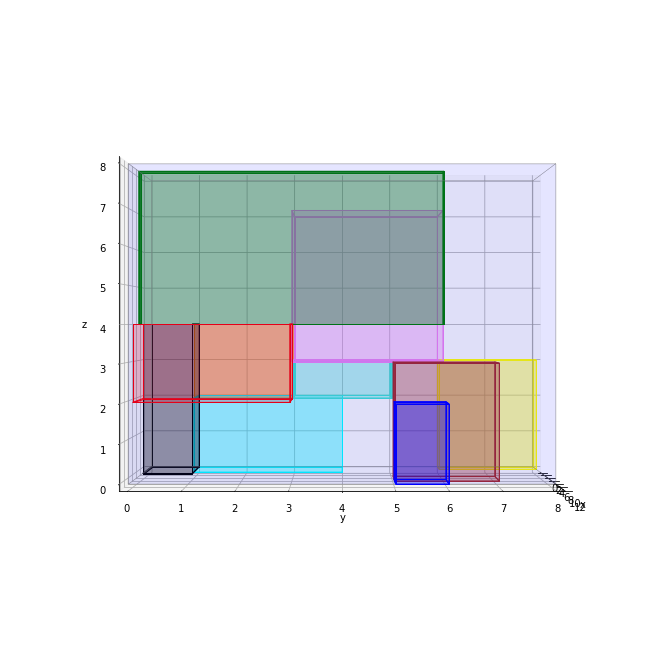

In [361]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(5,0,2)
FLT1=(5,0,2+h[1])
FRT1=(5,0+w[1],2+h[1])
FRB1=(5,0+w[1],2)

RLB1=(5+l[1],0,2)
RLT1=(5+l[1],0,2+h[1])
RRT1=(5+l[1],0+w[1],2+h[1])
RRB1=(5+l[1],0+w[1],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(6,0,4)
FLT2=(6,0,4+w[2])
FRT2=(6,0+l[2],4+w[2])
FRB2=(6,0+l[2],4)

RLB2=(6+h[2],0,4)
RLT2=(6+h[2],0,4+w[2])
RRT2=(6+h[2],0+l[2],4+w[2])
RRB2=(6+h[2],0+l[2],4)


FLB3=(0,1,2)
FLT3=(0,1,2+w[3])
FRT3=(0,1+h[3],2+w[3])
FRB3=(0,1+h[3],2)

RLB3=(0+l[3],1,2)
RLT3=(0+l[3],1,2+w[3])
RRT3=(0+l[3],1+h[3],2+w[3])
RRB3=(0+l[3],1+h[3],2)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(0,0,0)
FLT4=(0,0,0+w[4])
FRT4=(0,0+h[4],0+w[4])
FRB4=(0,0+h[4],0)

RLB4=(0+l[4],0,0)
RLT4=(0+l[4],0,0+w[4])
RRT4=(0+l[4],0+h[4],0+w[4])
RRB4=(0+l[4],0+h[4],0)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(0,1,0)
FLT5=(0,1,0+w[5])
FRT5=(0,1+h[5],0+w[5])
FRB5=(0,1+h[5],0)

RLB5=(0+l[5],1,0)
RLT5=(0+l[5],1,0+w[5])
RRT5=(0+l[5],1+h[5],0+w[5])
RRB5=(0+l[5],1+h[5],0)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(7,5,0)
FLT6=(7,5,0+l[6])
FRT6=(7,5+h[6],0+l[6])
FRB6=(7,5+h[6],0)

RLB6=(7+w[6],5,0)
RLT6=(7+w[6],5,0+l[6])
RRT6=(7+w[6],5+h[6],0+l[6])
RRB6=(7+w[6],5+h[6],0)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,3,3)
FLT7=(0,3,3+w[7])
FRT7=(0,3+h[7],3+w[7])
FRB7=(0,3+h[7],3)

RLB7=(0+l[7],3,3)
RLT7=(0+l[7],3,3+w[7])
RRT7=(0+l[7],3+h[7],3+w[7])
RRB7=(0+l[7],3+h[7],3)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(0,6,0)
FLT8=(0,6,0+l[8])
FRT8=(0,6+w[8],0+l[8])
FRB8=(0,6+w[8],0)

RLB8=(0+h[8],6,0)
RLT8=(0+h[8],6,0+l[8])
RRT8=(0+h[8],6+w[8],0+l[8])
RRB8=(0+h[8],6+w[8],0)

verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]

FLB9=(0,3,2)
FLT9=(0,3,2+h[9])
FRT9=(0,3+w[9],2+h[9])
FRB9=(0,3+w[9],2)

RLB9=(0+l[9],3,2)
RLT9=(0+l[9],3,2+h[9])
RRT9=(0+l[9],3+w[9],2+h[9])
RRB9=(0+l[9],3+w[9],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(9,5,0)
FLT10=(9,5,0+w[10])
FRT10=(9,5+h[10],0+w[10])
FRB10=(9,5+h[10],0)

RLB10=(9+l[10],5,0)
RLT10=(9+l[10],5,0+w[10])
RRT10=(9+l[10],5+h[10],0+w[10])
RRB10=(9+l[10],5+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,12)
ax.set_ylim3d(0,8)
ax.set_zlim3d(0,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='red', alpha=.1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='green', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='orange', linewidths=1, edgecolors='orange', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='black', linewidths=1, edgecolors='black', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='cyan', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='brown', linewidths=1, edgecolors='brown', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='violet', linewidths=1, edgecolors='violet', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='yellow', linewidths=1, edgecolors='yellow', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='turquoise', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='blue', alpha=.2))

ax.view_init(elev=0, azim=0)
plt.show()

In [121]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(5,0,0)
FLT1=(5,0,0+h[1])
FRT1=(5,0+w[1],0+h[1])
FRB1=(5,0+w[1],0)

RLB1=(5+l[1],0,0)
RLT1=(5+l[1],0,0+h[1])
RRT1=(5+l[1],0+w[1],0+h[1])
RRB1=(5+l[1],0+w[1],0)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(6,0,4)
FLT2=(6,0,4+w[2])
FRT2=(6,0+l[2],4+w[2])
FRB2=(6,0+l[2],4)

RLB2=(6+h[2],0,4)
RLT2=(6+h[2],0,4+w[2])
RRT2=(6+h[2],0+l[2],4+w[2])
RRB2=(6+h[2],0+l[2],4)



FLB3=(0,1,2)
FLT3=(0,1,2+w[3])
FRT3=(0,1+h[3],2+w[3])
FRB3=(0,1+h[3],2)

RLB3=(0+l[3],1,2)
RLT3=(0+l[3],1,2+w[3])
RRT3=(0+l[3],1+h[3],2+w[3])
RRB3=(0+l[3],1+h[3],2)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(0,0,0)
FLT4=(0,0,0+w[4])
FRT4=(0,0+h[4],0+w[4])
FRB4=(0,0+h[4],0)

RLB4=(0+l[4],0,0)
RLT4=(0+l[4],0,0+w[4])
RRT4=(0+l[4],0+h[4],0+w[4])
RRB4=(0+l[4],0+h[4],0)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(0,1,0)
FLT5=(0,1,0+w[5])
FRT5=(0,1+h[5],0+w[5])
FRB5=(0,1+h[5],0)

RLB5=(0+l[5],1,0)
RLT5=(0+l[5],1,0+w[5])
RRT5=(0+l[5],1+h[5],0+w[5])
RRB5=(0+l[5],1+h[5],0)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(7,5,0)
FLT6=(7,5,0+l[6])
FRT6=(7,5+h[6],0+l[6])
FRB6=(7,5+h[6],0)

RLB6=(7+w[6],5,0)
RLT6=(7+w[6],5,0+l[6])
RRT6=(7+w[6],5+h[6],0+l[6])
RRB6=(7+w[6],5+h[6],0)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,3,3)
FLT7=(0,3,3+w[7])
FRT7=(0,3+h[7],3+w[7])
FRB7=(0,3+h[7],3)

RLB7=(0+l[7],3,3)
RLT7=(0+l[7],3,3+w[7])
RRT7=(0+l[7],3+h[7],3+w[7])
RRB7=(0+l[7],3+h[7],3)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(0,6,0)
FLT8=(0,6,0+l[8])
FRT8=(0,6+w[8],0+l[8])
FRB8=(0,6+w[8],0)

RLB8=(0+h[8],6,0)
RLT8=(0+h[8],6,0+l[8])
RRT8=(0+h[8],6+w[8],0+l[8])
RRB8=(0+h[8],6+w[8],0)

verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]

FLB9=(0,3,2)
FLT9=(0,3,2+h[9])
FRT9=(0,3+w[9],2+h[9])
FRB9=(0,3+w[9],2)

RLB9=(0+l[9],3,2)
RLT9=(0+l[9],3,2+h[9])
RRT9=(0+l[9],3+w[9],2+h[9])
RRB9=(0+l[9],3+w[9],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(9,5,0)
FLT10=(9,5,0+w[10])
FRT10=(9,5+h[10],0+w[10])
FRB10=(9,5+h[10],0)

RLB10=(9+l[10],5,0)
RLT10=(9+l[10],5,0+w[10])
RRT10=(9+l[10],5+h[10],0+w[10])
RRB10=(9+l[10],5+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,12)
ax.set_ylim3d(0,8)
ax.set_zlim3d(0,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='orange', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='black', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='brown', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='violet', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='yellow', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='black', alpha=1))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='black', alpha=1))

#ax.view_init(elev=0, azim=45)
plt.show()

<IPython.core.display.Javascript object>

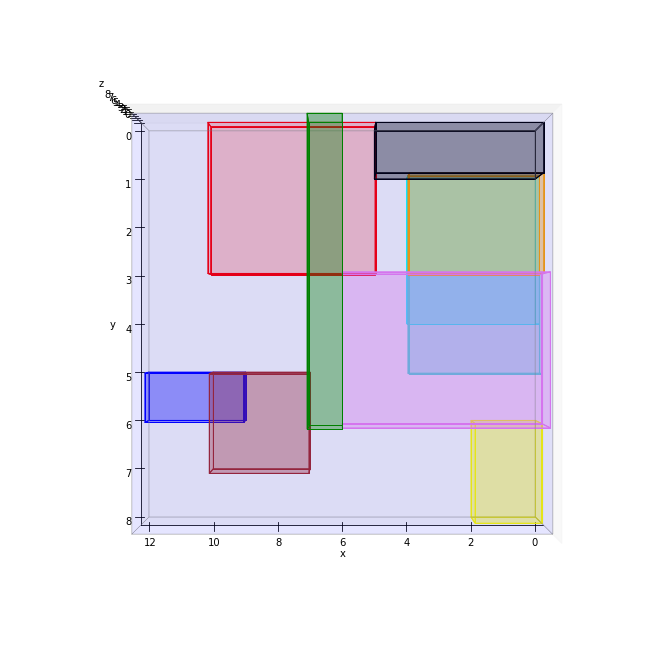

In [383]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(5,0,2)
FLT1=(5,0,2+h[1])
FRT1=(5,0+w[1],2+h[1])
FRB1=(5,0+w[1],2)

RLB1=(5+l[1],0,2)
RLT1=(5+l[1],0,2+h[1])
RRT1=(5+l[1],0+w[1],2+h[1])
RRB1=(5+l[1],0+w[1],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(6,0,4)
FLT2=(6,0,4+w[2])
FRT2=(6,0+l[2],4+w[2])
FRB2=(6,0+l[2],4)

RLB2=(6+h[2],0,4)
RLT2=(6+h[2],0,4+w[2])
RRT2=(6+h[2],0+l[2],4+w[2])
RRB2=(6+h[2],0+l[2],4)


FLB3=(0,1,2)
FLT3=(0,1,2+w[3])
FRT3=(0,1+h[3],2+w[3])
FRB3=(0,1+h[3],2)

RLB3=(0+l[3],1,2)
RLT3=(0+l[3],1,2+w[3])
RRT3=(0+l[3],1+h[3],2+w[3])
RRB3=(0+l[3],1+h[3],2)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(0,0,0)
FLT4=(0,0,0+w[4])
FRT4=(0,0+h[4],0+w[4])
FRB4=(0,0+h[4],0)

RLB4=(0+l[4],0,0)
RLT4=(0+l[4],0,0+w[4])
RRT4=(0+l[4],0+h[4],0+w[4])
RRB4=(0+l[4],0+h[4],0)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(0,1,0)
FLT5=(0,1,0+w[5])
FRT5=(0,1+h[5],0+w[5])
FRB5=(0,1+h[5],0)

RLB5=(0+l[5],1,0)
RLT5=(0+l[5],1,0+w[5])
RRT5=(0+l[5],1+h[5],0+w[5])
RRB5=(0+l[5],1+h[5],0)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(7,5,0)
FLT6=(7,5,0+l[6])
FRT6=(7,5+h[6],0+l[6])
FRB6=(7,5+h[6],0)

RLB6=(7+w[6],5,0)
RLT6=(7+w[6],5,0+l[6])
RRT6=(7+w[6],5+h[6],0+l[6])
RRB6=(7+w[6],5+h[6],0)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,3,3)
FLT7=(0,3,3+w[7])
FRT7=(0,3+h[7],3+w[7])
FRB7=(0,3+h[7],3)

RLB7=(0+l[7],3,3)
RLT7=(0+l[7],3,3+w[7])
RRT7=(0+l[7],3+h[7],3+w[7])
RRB7=(0+l[7],3+h[7],3)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(0,6,0)
FLT8=(0,6,0+l[8])
FRT8=(0,6+w[8],0+l[8])
FRB8=(0,6+w[8],0)

RLB8=(0+h[8],6,0)
RLT8=(0+h[8],6,0+l[8])
RRT8=(0+h[8],6+w[8],0+l[8])
RRB8=(0+h[8],6+w[8],0)

verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]

FLB9=(0,3,2)
FLT9=(0,3,2+h[9])
FRT9=(0,3+w[9],2+h[9])
FRB9=(0,3+w[9],2)

RLB9=(0+l[9],3,2)
RLT9=(0+l[9],3,2+h[9])
RRT9=(0+l[9],3+w[9],2+h[9])
RRB9=(0+l[9],3+w[9],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(9,5,0)
FLT10=(9,5,0+w[10])
FRT10=(9,5+h[10],0+w[10])
FRB10=(9,5+h[10],0)

RLB10=(9+l[10],5,0)
RLT10=(9+l[10],5,0+w[10])
RRT10=(9+l[10],5+h[10],0+w[10])
RRB10=(9+l[10],5+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,12)
ax.set_ylim3d(0,8)
ax.set_zlim3d(0,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='red', alpha=.1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='green', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='orange', linewidths=1, edgecolors='orange', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='black', linewidths=1, edgecolors='black', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='cyan', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='brown', linewidths=1, edgecolors='brown', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='violet', linewidths=1, edgecolors='violet', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='yellow', linewidths=1, edgecolors='yellow', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='turquoise', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='blue', alpha=.2))

ax.view_init(elev=90, azim=90)
plt.show()

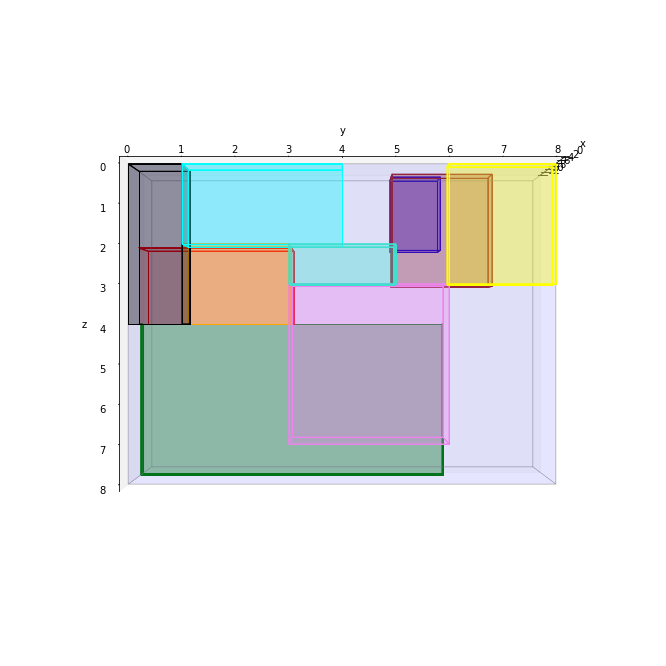

In [384]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(5,0,2)
FLT1=(5,0,2+h[1])
FRT1=(5,0+w[1],2+h[1])
FRB1=(5,0+w[1],2)

RLB1=(5+l[1],0,2)
RLT1=(5+l[1],0,2+h[1])
RRT1=(5+l[1],0+w[1],2+h[1])
RRB1=(5+l[1],0+w[1],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(6,0,4)
FLT2=(6,0,4+w[2])
FRT2=(6,0+l[2],4+w[2])
FRB2=(6,0+l[2],4)

RLB2=(6+h[2],0,4)
RLT2=(6+h[2],0,4+w[2])
RRT2=(6+h[2],0+l[2],4+w[2])
RRB2=(6+h[2],0+l[2],4)


FLB3=(0,1,2)
FLT3=(0,1,2+w[3])
FRT3=(0,1+h[3],2+w[3])
FRB3=(0,1+h[3],2)

RLB3=(0+l[3],1,2)
RLT3=(0+l[3],1,2+w[3])
RRT3=(0+l[3],1+h[3],2+w[3])
RRB3=(0+l[3],1+h[3],2)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(0,0,0)
FLT4=(0,0,0+w[4])
FRT4=(0,0+h[4],0+w[4])
FRB4=(0,0+h[4],0)

RLB4=(0+l[4],0,0)
RLT4=(0+l[4],0,0+w[4])
RRT4=(0+l[4],0+h[4],0+w[4])
RRB4=(0+l[4],0+h[4],0)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(0,1,0)
FLT5=(0,1,0+w[5])
FRT5=(0,1+h[5],0+w[5])
FRB5=(0,1+h[5],0)

RLB5=(0+l[5],1,0)
RLT5=(0+l[5],1,0+w[5])
RRT5=(0+l[5],1+h[5],0+w[5])
RRB5=(0+l[5],1+h[5],0)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(7,5,0)
FLT6=(7,5,0+l[6])
FRT6=(7,5+h[6],0+l[6])
FRB6=(7,5+h[6],0)

RLB6=(7+w[6],5,0)
RLT6=(7+w[6],5,0+l[6])
RRT6=(7+w[6],5+h[6],0+l[6])
RRB6=(7+w[6],5+h[6],0)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,3,3)
FLT7=(0,3,3+w[7])
FRT7=(0,3+h[7],3+w[7])
FRB7=(0,3+h[7],3)

RLB7=(0+l[7],3,3)
RLT7=(0+l[7],3,3+w[7])
RRT7=(0+l[7],3+h[7],3+w[7])
RRB7=(0+l[7],3+h[7],3)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(0,6,0)
FLT8=(0,6,0+l[8])
FRT8=(0,6+w[8],0+l[8])
FRB8=(0,6+w[8],0)

RLB8=(0+h[8],6,0)
RLT8=(0+h[8],6,0+l[8])
RRT8=(0+h[8],6+w[8],0+l[8])
RRB8=(0+h[8],6+w[8],0)

verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]

FLB9=(0,3,2)
FLT9=(0,3,2+h[9])
FRT9=(0,3+w[9],2+h[9])
FRB9=(0,3+w[9],2)

RLB9=(0+l[9],3,2)
RLT9=(0+l[9],3,2+h[9])
RRT9=(0+l[9],3+w[9],2+h[9])
RRB9=(0+l[9],3+w[9],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(9,5,0)
FLT10=(9,5,0+w[10])
FRT10=(9,5+h[10],0+w[10])
FRB10=(9,5+h[10],0)

RLB10=(9+l[10],5,0)
RLT10=(9+l[10],5,0+w[10])
RRT10=(9+l[10],5+h[10],0+w[10])
RRB10=(9+l[10],5+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,12)
ax.set_ylim3d(0,8)
ax.set_zlim3d(0,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='red', alpha=.1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='green', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='orange', linewidths=1, edgecolors='orange', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='black', linewidths=1, edgecolors='black', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='cyan', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='brown', linewidths=1, edgecolors='brown', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='violet', linewidths=1, edgecolors='violet', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='yellow', linewidths=1, edgecolors='yellow', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='turquoise', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='blue', alpha=.2))

ax.view_init(elev=-180, azim=0)
plt.show()

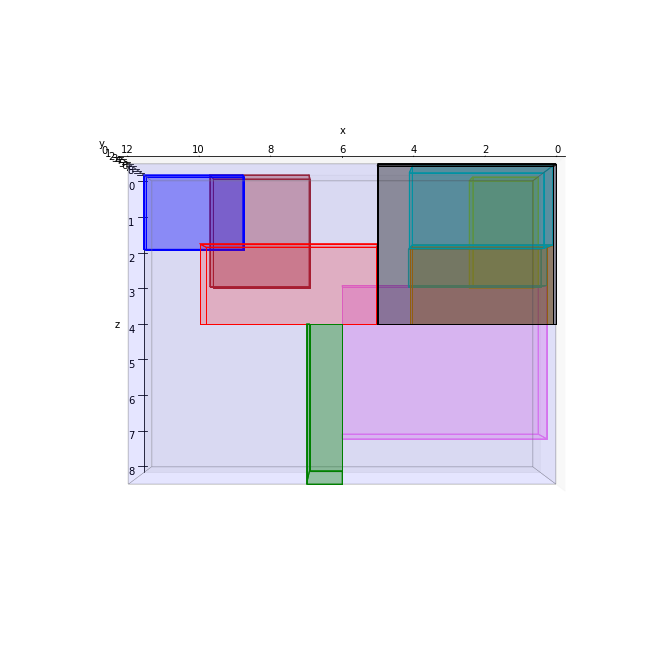

In [385]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# create list of corners
z = list(product([-1,1], repeat=3))

FLB=(0,0,0)
FLT=(0,0,H)
FRT=(0,W,H)
FRB=(0,W,0)

RLB=(L,0,0)
RLT=(L,0,H)
RRT=(L,W,H)
RRB=(L,W,0)

verts=[  [FLB,FLT,FRT,FRB], [FLB,FLT,RLT,RLB],[FLT,FRT,RRT,RLT],[RRT,FRT,FRB,RRB],[RLB,FLB,FRB,RRB],[RLB,RLT,RRT,RRB]

]



FLB1=(5,0,2)
FLT1=(5,0,2+h[1])
FRT1=(5,0+w[1],2+h[1])
FRB1=(5,0+w[1],2)

RLB1=(5+l[1],0,2)
RLT1=(5+l[1],0,2+h[1])
RRT1=(5+l[1],0+w[1],2+h[1])
RRB1=(5+l[1],0+w[1],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts1=[  [FLB1,FLT1,FRT1,FRB1], [FLB1,FLT1,RLT1,RLB1],[FLT1,FRT1,RRT1,RLT1],[RRT1,FRT1,FRB1,RRB1],[RLB1,FLB1,FRB1,RRB1],[RLB1,RLT1,RRT1,RRB1]

]

FLB2=(6,0,4)
FLT2=(6,0,4+w[2])
FRT2=(6,0+l[2],4+w[2])
FRB2=(6,0+l[2],4)

RLB2=(6+h[2],0,4)
RLT2=(6+h[2],0,4+w[2])
RRT2=(6+h[2],0+l[2],4+w[2])
RRB2=(6+h[2],0+l[2],4)


FLB3=(0,1,2)
FLT3=(0,1,2+w[3])
FRT3=(0,1+h[3],2+w[3])
FRB3=(0,1+h[3],2)

RLB3=(0+l[3],1,2)
RLT3=(0+l[3],1,2+w[3])
RRT3=(0+l[3],1+h[3],2+w[3])
RRB3=(0+l[3],1+h[3],2)


# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]


verts2=[  [FLB2,FLT2,FRT2,FRB2], [FLB2,FLT2,RLT2,RLB2],[FLT2,FRT2,RRT2,RLT2],[RRT2,FRT2,FRB2,RRB2],[RLB2,FLB2,FRB2,RRB2],[RLB2,RLT2,RRT2,RRB2]]
verts3=[  [FLB3,FLT3,FRT3,FRB3], [FLB3,FLT3,RLT3,RLB3],[FLT3,FRT3,RRT3,RLT3],[RRT3,FRT3,FRB3,RRB3],[RLB3,FLB3,FRB3,RRB3],[RLB3,RLT3,RRT3,RRB3]]


FLB4=(0,0,0)
FLT4=(0,0,0+w[4])
FRT4=(0,0+h[4],0+w[4])
FRB4=(0,0+h[4],0)

RLB4=(0+l[4],0,0)
RLT4=(0+l[4],0,0+w[4])
RRT4=(0+l[4],0+h[4],0+w[4])
RRB4=(0+l[4],0+h[4],0)

verts4=[  [FLB4,FLT4,FRT4,FRB4], [FLB4,FLT4,RLT4,RLB4],[FLT4,FRT4,RRT4,RLT4],[RRT4,FRT4,FRB4,RRB4],[RLB4,FLB4,FRB4,RRB4],[RLB4,RLT4,RRT4,RRB4]]


FLB5=(0,1,0)
FLT5=(0,1,0+w[5])
FRT5=(0,1+h[5],0+w[5])
FRB5=(0,1+h[5],0)

RLB5=(0+l[5],1,0)
RLT5=(0+l[5],1,0+w[5])
RRT5=(0+l[5],1+h[5],0+w[5])
RRB5=(0+l[5],1+h[5],0)

verts5=[  [FLB5,FLT5,FRT5,FRB5], [FLB5,FLT5,RLT5,RLB5],[FLT5,FRT5,RRT5,RLT5],[RRT5,FRT5,FRB5,RRB5],[RLB5,FLB5,FRB5,RRB5],[RLB5,RLT5,RRT5,RRB5]]

FLB6=(7,5,0)
FLT6=(7,5,0+l[6])
FRT6=(7,5+h[6],0+l[6])
FRB6=(7,5+h[6],0)

RLB6=(7+w[6],5,0)
RLT6=(7+w[6],5,0+l[6])
RRT6=(7+w[6],5+h[6],0+l[6])
RRB6=(7+w[6],5+h[6],0)

verts6=[  [FLB6,FLT6,FRT6,FRB6], [FLB6,FLT6,RLT6,RLB6],[FLT6,FRT6,RRT6,RLT6],[RRT6,FRT6,FRB6,RRB6],[RLB6,FLB6,FRB6,RRB6],[RLB6,RLT6,RRT6,RRB6]]


FLB7=(0,3,3)
FLT7=(0,3,3+w[7])
FRT7=(0,3+h[7],3+w[7])
FRB7=(0,3+h[7],3)

RLB7=(0+l[7],3,3)
RLT7=(0+l[7],3,3+w[7])
RRT7=(0+l[7],3+h[7],3+w[7])
RRB7=(0+l[7],3+h[7],3)

verts7=[  [FLB7,FLT7,FRT7,FRB7], [FLB7,FLT7,RLT7,RLB7],[FLT7,FRT7,RRT7,RLT7],[RRT7,FRT7,FRB7,RRB7],[RLB7,FLB7,FRB7,RRB7],[RLB7,RLT7,RRT7,RRB7]]


FLB8=(0,6,0)
FLT8=(0,6,0+l[8])
FRT8=(0,6+w[8],0+l[8])
FRB8=(0,6+w[8],0)

RLB8=(0+h[8],6,0)
RLT8=(0+h[8],6,0+l[8])
RRT8=(0+h[8],6+w[8],0+l[8])
RRB8=(0+h[8],6+w[8],0)

verts8=[  [FLB8,FLT8,FRT8,FRB8], [FLB8,FLT8,RLT8,RLB8],[FLT8,FRT8,RRT8,RLT8],[RRT8,FRT8,FRB8,RRB8],[RLB8,FLB8,FRB8,RRB8],[RLB8,RLT8,RRT8,RRB8]]

FLB9=(0,3,2)
FLT9=(0,3,2+h[9])
FRT9=(0,3+w[9],2+h[9])
FRB9=(0,3+w[9],2)

RLB9=(0+l[9],3,2)
RLT9=(0+l[9],3,2+h[9])
RRT9=(0+l[9],3+w[9],2+h[9])
RRB9=(0+l[9],3+w[9],2)

# set verts connectors
#verts = [[z[0],z[1],z[5],z[4]], [z[4],z[6],z[7],z[5]], [z[7], z[6], z[2], z[3]], [z[2], z[0], z[1], z[3]],
 #        [z[5], z[7], z[3], z[1]], [z[0], z[2], z[6], z[4]]]

verts9=[  [FLB9,FLT9,FRT9,FRB9], [FLB9,FLT9,RLT9,RLB9],[FLT9,FRT9,RRT9,RLT9],[RRT9,FRT9,FRB9,RRB9],[RLB9,FLB9,FRB9,RRB9],[RLB9,RLT9,RRT9,RRB9]

]

FLB10=(9,5,0)
FLT10=(9,5,0+w[10])
FRT10=(9,5+h[10],0+w[10])
FRB10=(9,5+h[10],0)

RLB10=(9+l[10],5,0)
RLT10=(9+l[10],5,0+w[10])
RRT10=(9+l[10],5+h[10],0+w[10])
RRB10=(9+l[10],5+h[10],0)

verts10=[  [FLB10,FLT10,FRT10,FRB10], [FLB10,FLT10,RLT10,RLB10],[FLT10,FRT10,RRT10,RLT10],[RRT10,FRT10,FRB10,RRB10],[RLB10,FLB10,FRB10,RRB10],[RLB10,RLT10,RRT10,RRB10]]

ax.set_xlim3d(0,12)
ax.set_ylim3d(0,8)
ax.set_zlim3d(0,8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
# plot sides
ax.add_collection3d(Poly3DCollection(verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.05))
ax.add_collection3d(Poly3DCollection(verts1,facecolors='red', linewidths=1, edgecolors='red', alpha=.1))
ax.add_collection3d(Poly3DCollection(verts2,facecolors='green', linewidths=1, edgecolors='green', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts3,facecolors='orange', linewidths=1, edgecolors='orange', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts4,facecolors='black', linewidths=1, edgecolors='black', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts5,facecolors='cyan', linewidths=1, edgecolors='cyan', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts6,facecolors='brown', linewidths=1, edgecolors='brown', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts7,facecolors='violet', linewidths=1, edgecolors='violet', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts8,facecolors='yellow', linewidths=1, edgecolors='yellow', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts9,facecolors='turquoise', linewidths=1, edgecolors='turquoise', alpha=.2))
ax.add_collection3d(Poly3DCollection(verts10,facecolors='blue', linewidths=1, edgecolors='blue', alpha=.2))

ax.view_init(elev=-180, azim=90)
plt.show()

In [337]:
l,h,w

({1: 5, 2: 6, 3: 4, 4: 5, 5: 4, 6: 3, 7: 6, 8: 3, 9: 4, 10: 3},
 {1: 2, 2: 1, 3: 2, 4: 1, 5: 3, 6: 2, 7: 3, 8: 2, 9: 1, 10: 1},
 {1: 3, 2: 4, 3: 2, 4: 4, 5: 2, 6: 3, 7: 4, 8: 2, 9: 2, 10: 2})

In [301]:
z = list(product([-1,1], repeat=3))


In [302]:
z

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [307]:
list(product([-1,1],[-1,1],[-1,1]))

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [308]:
z[0]

(-1, -1, -1)